In [103]:
from skimage.io import imread
from skimage.io.collection import alphanumeric_key
from dask import delayed
import dask.array as da
from glob import glob

filenames = sorted(glob(r"C:\dev\3d-transporters\Data\gaba\*.tif"), key=alphanumeric_key)
# read the first file to get the shape and dtype

sample = imread(filenames[0])

lazy_imread = delayed(imread)  # lazy reader
lazy_arrays = [lazy_imread(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(delayed_reader, shape=sample.shape, dtype=sample.dtype)
    for delayed_reader in lazy_arrays
]
# Stack into one large dask.array
stack = da.stack(dask_arrays, axis=0)
stack.shape  # (nfiles, nz, ny, nx)

# in jupyter notebook the repr of a dask stack provides a useful visual:
stack

dask.array<stack, shape=(37, 1024, 1024), dtype=uint16, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>

In [1]:
import napari
from napari_plugin_engine import napari_hook_implementation
import numpy as np
from scipy import ndimage as ndi
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.morphology import local_maxima
from dask_image.imread import imread
from scipy import ndimage as ndi



def voronoi_otsu_labeling(image:"napari.types.ImageData", spot_sigma: float = 2, outline_sigma: float = 2) -> "napari.types.LabelsData":

    image = np.asarray(image)

    # blur and detect local maxima
    blurred_spots = gaussian(image, spot_sigma)
    spot_centroids = local_maxima(blurred_spots)

    # blur and threshold
    blurred_outline = gaussian(image, outline_sigma)
    threshold = threshold_otsu(blurred_outline)
    binary_otsu = blurred_outline > threshold

    # determine local maxima within the thresholded area
    remaining_spots = spot_centroids * binary_otsu

    # start from remaining spots and flood binary image with labels
    labeled_spots = label(remaining_spots)
    labels = watershed(binary_otsu, labeled_spots, mask=binary_otsu)

    return labels

In [105]:
spacing = np.array([1, 1, 1]) # spacing in x, y, z use microscope metadata for real measurements
# add VGaT image
VGaT = imread(r"C:\dev\3d-transporters\Data\gaba\*tif")
viewer = napari.view_image(
    VGaT,
    scale=spacing,
    contrast_limits=[0, 2000],
    multiscale=False
)

In [106]:
# use voronoi_otsu_labeling to get VGaT labels
VGaT_labels = voronoi_otsu_labeling(VGaT, spot_sigma = 0.5, outline_sigma = 1)

VGaT_labels_viewer = viewer.add_labels(
    VGaT_labels,
    scale=spacing,
)

In [107]:
# add VGluT3 images
VGluT3 = imread(r"C:\dev\3d-transporters\Data\glu\*.tif")
viewer.add_image(
    VGluT3,
    scale=spacing,
    contrast_limits=[0, 2000],
    multiscale=False
)
# use voronoi_otsu_labeling to get VGluT3 labels
VGluT3_lables = voronoi_otsu_labeling(VGluT3)

VGluT3_lables_viewer = viewer.add_labels(
    VGluT3_lables,
    scale=spacing,
)

In [108]:
# create viewer for colocalized labels
lables_overlap = VGluT3_lables & VGaT_labels # creates overlap mask
labels_colocal_viewer = viewer.add_labels(
    lables_overlap,
    scale=spacing,
)

In [ ]:
# create a surface for each label in VGaT_labels
from skimage import measure
verts, faces, _, values = measure.marching_cubes(VGaT_labels, 0)
surface_area_pixels = measure.mesh_surface_area(verts, faces)

VGaT_labels_surface_viewer=viewer.add_surface((verts[:, [2, 0, 1]], faces, np.linspace(0, 1, len(verts))), name='VGaT surface', rotate = (90, 0, 0),)
VGaT_labels_surface_viewer.normals.face.visible = False
VGaT_labels_surface_viewer.normals.vertex.visible = False
VGaT_labels_surface_viewer.wireframe.visible = True

In [ ]:
# create a surface for each label in VGluT3_lables
verts, faces, _, values = measure.marching_cubes(VGluT3_lables, 0)
surface_area_pixels = measure.mesh_surface_area(verts, faces)

VGluT3_lables_surface_viewer=viewer.add_surface((verts[:, [2, 0, 1]], faces, np.linspace(0, 1, len(verts))), name='VGluT3 surface', rotate = (90, 0, 0),)
VGluT3_lables_surface_viewer.normals.face.visible = False
VGluT3_lables_surface_viewer.normals.vertex.visible = False
VGluT3_lables_surface_viewer.wireframe.visible = True

# ANALYSIS

In [111]:
VGaT_overlap = VGaT_labels & lables_overlap

In [112]:
import pandas as pd
from skimage.measure import regionprops_table

# measure the voxel counts
measurements_table = regionprops_table(lables_overlap, properties=['label', 'area',])

# convert to a dataframe
measurements_df = pd.DataFrame(measurements_table)
measurements_df

,label,area
0,1,5415
1,2,6134
2,3,3195
3,4,6419
4,5,2198
...,...,...
1361,3440,1
1362,3448,95
1363,3454,17
1364,3455,103


In [113]:
# Measure VGaT overlap with VGluT3
measurements_table = regionprops_table(VGaT_overlap, properties=['label', 'area', 'coords'])

# convert to a dataframe
measurements_df = pd.DataFrame(measurements_table)
measurements_df

,label,area,coords
0,1,5415,"[[0, 80, 790], [0, 81, 788], [0, 81, 789], [0,..."
1,2,6134,"[[0, 6, 129], [0, 6, 130], [0, 7, 128], [0, 7,..."
2,3,3195,"[[0, 116, 823], [0, 116, 824], [0, 116, 825], ..."
3,4,6419,"[[0, 19, 211], [0, 19, 212], [0, 19, 213], [0,..."
4,5,2198,"[[0, 143, 297], [0, 143, 298], [0, 144, 297], ..."
...,...,...,...
1361,3440,1,"[[36, 820, 474]]"
1362,3448,95,"[[34, 820, 356], [34, 821, 356], [34, 829, 357..."
1363,3454,17,"[[34, 830, 594], [35, 829, 593], [35, 830, 593..."
1364,3455,103,"[[32, 831, 697], [33, 830, 695], [33, 830, 696..."


In [114]:
# Measure VGluT3 labels
VGluT3_lables_table = regionprops_table(VGluT3_lables, properties=['label', 'area', 'coords'])

# convert to a dataframe
VGluT3_lables_df = pd.DataFrame(VGluT3_lables_table)
VGluT3_lables_df

,label,area,coords
0,1,9,"[[0, 0, 115], [0, 0, 116], [0, 0, 117], [0, 0,..."
1,2,174,"[[0, 0, 784], [0, 0, 785], [0, 0, 786], [0, 0,..."
2,3,62,"[[0, 0, 485], [0, 0, 486], [0, 0, 487], [0, 0,..."
3,4,588,"[[0, 0, 524], [0, 0, 525], [0, 0, 526], [0, 0,..."
4,5,182,"[[0, 3, 478], [0, 4, 477], [0, 4, 478], [0, 4,..."
...,...,...,...
12505,12506,251,"[[28, 1023, 207], [28, 1023, 208], [29, 1021, ..."
12506,12507,345,"[[28, 1023, 274], [28, 1023, 275], [28, 1023, ..."
12507,12508,254,"[[29, 1019, 674], [29, 1019, 675], [30, 1018, ..."
12508,12509,85,"[[30, 1023, 726], [30, 1023, 727], [31, 1022, ..."


In [115]:
# measure the voxel counts
VGaT_labels_table = regionprops_table(VGaT_labels, properties=['label', 'area', 'coords'])

# convert to a dataframe
VGaT_labels_df = pd.DataFrame(VGaT_labels_table)
VGaT_labels_df

,label,area,coords
0,1,30,"[[0, 20, 222], [0, 20, 223], [0, 20, 224], [0,..."
1,2,71,"[[0, 20, 501], [0, 21, 500], [0, 21, 501], [0,..."
2,3,531,"[[0, 20, 775], [0, 20, 776], [0, 21, 774], [0,..."
3,4,188,"[[0, 31, 123], [0, 31, 124], [0, 32, 123], [0,..."
4,5,86,"[[0, 34, 574], [0, 34, 575], [0, 35, 573], [0,..."
...,...,...,...
3487,3488,127,"[[31, 999, 444], [31, 1000, 443], [31, 1000, 4..."
3488,3489,140,"[[32, 1008, 244], [32, 1008, 245], [32, 1008, ..."
3489,3490,2,"[[36, 1011, 256], [36, 1012, 256]]"
3490,3491,15,"[[35, 1013, 938], [35, 1013, 939], [35, 1014, ..."


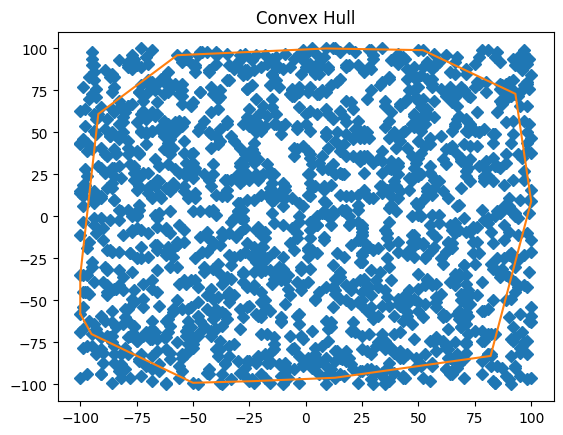

In [33]:
import convexhull
import matplotlib.pyplot as plt
import random
from collections import namedtuple  

def get_convex_hull():
    Point = namedtuple('Point', 'x y')  
    ch = convexhull.ConvexHull()
    for _ in range(50):
        ch.add(Point(random.randint(-100, 100), random.randint(-100, 100)))

    ch.display()


get_convex_hull()

In [93]:
def get_convex_hull():
    Point = namedtuple('Point', 'x y')  
    ch2 = convexhull.ConvexHull()
    ch2.reset()
    for _ in range(100):
        ch2.add(Point(random.randint(-100, 100), random.randint(-100, 100)))

    ch2.display()


get_convex_hull()

AttributeError: 'ConvexHull' object has no attribute 'reset'